In [1]:
#Imports
!pip install scikit-plot

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, f_classif
from sklearn.impute import SimpleImputer, IterativeImputer # new
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.utils import resample

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, OneClassSVM

In [2]:
# Importing the data as pandas dataframes
train_df = pd.read_csv("brighton-a-memorable-city/training.csv")
test_df = pd.read_csv("brighton-a-memorable-city/testing.csv")
additional_df = pd.read_csv('brighton-a-memorable-city/additional_training.csv')
annotation_df = pd.read_csv('brighton-a-memorable-city/annotation_confidence.csv')
train_df.shape, test_df.shape, additional_df.shape, annotation_df.shape

((247, 4610), (11874, 4609), (2219, 4610), (2466, 2))

In [3]:
# Used as the random_state in all the algorithms
SEED = 40

## Data preprocessing

In [4]:
# Impute the missing values additional_training.csv using mean strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_df = pd.DataFrame(imputer.fit_transform(additional_df), columns=additional_df.columns)

# Combine the given training data with imputed additional data
merged_train_df = pd.concat([train_df, imputed_df])
merged_train_df.shape

(2466, 4610)

In [5]:
# Adding the confidence values

# Obtain confidence values from annottion_confidecnce.csv file
merged_train_df['confidence'] = annotation_df['confidence']


# Group the dataframe by prediction values
pred_group = merged_train_df.groupby('prediction')
parts = []
for label, group_df in pred_group:
    if label == 1:
        # For 1 labels, the new label becomes the confidence values
        group_df['prediction'] = group_df['confidence']
    elif label == 0:
        # For 0 labels, the new label becomes negative of confidence values
        group_df['prediction'] = -group_df['confidence']
    parts.append(group_df)
        
# Merge the confidence values
merged_train_df = pd.concat(parts)

# Removing the ID and confidence column
test_df.drop('ID', axis=1, inplace=True, errors='ignore')
merged_train_df.drop(['ID', 'confidence'], axis=1, inplace=True, errors='ignore')
merged_train_df.head()

/Users/dansimons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/dansimons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,...,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,prediction
9,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.81523,0.0,0.00000,0.00000,...,0.008282,0.030176,0.044697,0.018059,0.004594,0.026089,0.035976,0.011206,0.005505,-0.66
10,0.0,0.00000,0.0,0.18052,0.0,0.26945,0.00000,0.0,0.00000,0.70977,...,0.011401,0.048368,0.051525,0.038384,0.016819,0.029425,0.024700,0.024170,0.033528,-0.66
16,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.45658,0.0,0.00000,0.00000,...,0.014849,0.005769,0.040127,0.038519,0.030636,0.029696,0.068332,0.039839,0.038854,-0.66
29,0.0,0.21047,0.0,0.13703,0.0,0.00000,0.00000,0.0,0.00000,0.19678,...,0.016646,0.021506,0.052330,0.025564,0.015887,0.012836,0.029093,0.023116,0.012955,-0.66
30,0.0,0.64703,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.62934,0.29202,...,0.012900,0.010985,0.032555,0.036716,0.015634,0.007760,0.033190,0.043284,0.012399,-0.66


### Train-test-split

In [6]:
def get_train_test_data(df, target_col='prediction', 
                        undersample=True,
                        multiplier=1, confidence_labels=False):
    Y = df[target_col]
    X = df.drop(target_col, axis=1)
    
    if undersample:
        # Undersampling
        df_with_labels = pd.concat([X, Y], axis=1)
        if confidence_labels:
            # If confidence lables are applied, filter minority and majority by signs
            df_majority = df_with_labels[ df_with_labels[target_col] > 0]
            df_minority = df_with_labels[ df_with_labels[target_col] < 0]
        else:
            # Else, 1 is the majority class lable
            df_majority = df_with_labels[ df_with_labels[target_col] == 1]
            df_minority = df_with_labels[ df_with_labels[target_col] == 0]
        
        if undersample:
            n_samples = int(df_minority.shape[0] * multiplier)
            df_majority = resample(df_majority, replace=False, n_samples=n_samples, random_state=SEED)
        
        df_with_labels = pd.concat([df_majority, df_minority])
        X = df_with_labels.drop(target_col, axis=1)
        Y = df_with_labels[target_col]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED, shuffle=True, stratify=Y)
        
    return X_train, X_test, Y_train, Y_test

In [7]:
# Get train and validation data
X_train, X_val, Y_train, Y_val = get_train_test_data(merged_train_df, undersample=True, multiplier=3, confidence_labels=True)

# Label ecnoding, converting real prediction values into discrete lables for classfication
le = preprocessing.LabelEncoder()
Y_train_lab = le.fit_transform(Y_train)
Y_val_lab = le.transform(Y_val)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1043, 4608), (261, 4608), (1043,), (261,))

In [8]:
Y_train.value_counts()

 0.66    391
 1.00    391
-0.66    158
-1.00    103
Name: prediction, dtype: int64

## Keras models

In [9]:
#Making MLP with keras for regresssion - outputs 1 value - real value
def get_regression_model(input_size): # input size is the size of train features (the number of features)
    # Creating the model layer by layer
    model = tf.keras.Sequential([
        # First layer with relu activation function
        tf.keras.layers.Dense(128, activation='relu', input_shape=[input_size], kernel_initializer='he_uniform'),
        # Second layer
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
        # Final layer with 1 output size with linear activation because of regression
        tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal'),
    ])

    model.compile(loss='mean_squared_error',
                  # Optimizer
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  # Mean Squared error, Mean absolute error
                  metrics=['mse', 'mae']) 
    print(model.summary())
    return model

#making MLP with keras for classification - predicts probability of 4 classes 
def get_clf_model(input_size, output_size):
    # Use stochastic gradient descent optimizer
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # Building the model layer by layer
    model = tf.keras.Sequential([
        # First layer
        tf.keras.layers.Dense(128, activation='relu', input_shape=[input_size],
                              kernel_regularizer='l2'),
        # Add dropout layer to reduce overfitting
        tf.keras.layers.Dropout(0.5),
        # Second layer
        tf.keras.layers.Dense(16, activation='sigmoid', kernel_regularizer='l2'),
        # Another dropout layer
        tf.keras.layers.Dropout(0.5),
        # Final layer, it outputs probability values for every class
        tf.keras.layers.Dense(output_size, kernel_initializer='he_uniform', activation='sigmoid'),
        #tf.keras.layers.Activation('softmax'),
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    print(model.summary())
    return model

## Pipeline

In [10]:


#prints header of the graph
def print_header(header):
    size= len(header)
    print()
    print("="*size)
    print(header)
    print("="*size)
    
#As we used confidence values we created 4 classes - binarize turns these 4 classes in 2 classes    
def binarize(series, le, threshold=0):
    return pd.Series(le.inverse_transform(series)).map(lambda x: 1 if x > threshold else 0)

#Takes predictions of model & actual values & plots curve & other metrics
def compute_scores_print_report(predictions, actual_values, text, y_probas=None):
    print_header(text)
    print(classification_report(predictions, actual_values, digits=2))
    skplt.metrics.plot_confusion_matrix(actual_values, predictions)
    plt.show()
    #print(confusion_matrix(y_true=actual_values, y_pred=predictions))
    if y_probas is not None:
        skplt.metrics.plot_roc_curve(actual_values, y_probas,  curves=('micro'), title=f'{text} ROC curve')
        plt.show()
    
# creates the data that goes on the roc curve - validation only
def make_predictions_validation(clf, X_val, Y_val, le, text='', oh=False, prob_method='predict'):
    predictions = clf.predict(X_val)
    y_probas = None
    if prob_method == 'predict':
        y_probas = clf.predict_proba(X_val)
    if oh:
        predictions = [np.argmax(p) for p in predictions]
    #print(predictions, Y_val)
    return compute_scores_print_report(predictions, Y_val, text, y_probas)
    

# creates dataframe - later put in csv for use on kaggle 
def make_predictions(clf, test_df, confidence_values=True, le=None, oh=False,
                    threshold=0.0, text=''):
    
    # Creating the result dataframe (the one that needs to be submitted to kaggle)
    results = pd.DataFrame(columns=['ID', 'prediction'])
    # ID column (starts from 1)
    results['ID'] = test_df.index + 1
    
    # Make predictions
    predictions = clf.predict(test_df)
    
    # TOtal rows
    total = len(predictions)
    
    if oh: 
        # One hot vectorization, used for keras classifier
        # Selecct the class with max probability
        predictions = [np.argmax(p) for p in predictions]
        
    if confidence_values:
        if le:
            # Get back the real values from labelencoder
            predictions = le.inverse_transform(predictions)
    

    # Convert into either 0 or 1 based on the threshold
    # casting to integer as submission can't be float
    results['prediction'] = (predictions > threshold).astype(int)
    
    
    # Printing the percetange of 1 and 0s in our prediction
    ones = results['prediction'].sum()
    zeroes = total - ones
    zero_p = zeroes/total * 100.0
    ones_p = ones/total * 100.0
    print(f'Zero percentage {zero_p} Ones Percentage {ones_p}')
    # Return the results
    return results

In [11]:
help(skplt.metrics.plot_roc_curve)

Help on function plot_roc_curve in module scikitplot.metrics:

plot_roc_curve(y_true, y_probas, title='ROC Curves', curves=('micro', 'macro', 'each_class'), ax=None, figsize=None, cmap='nipy_spectral', title_fontsize='large', text_fontsize='medium')
    DEPRECATED: This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
    
    Generates the ROC curves from labels and predicted scores/probabilities
    
        Args:
            y_true (array-like, shape (n_samples)):
                Ground truth (correct) target values.
    
            y_probas (array-like, shape (n_samples, n_classes)):
                Prediction probabilities for each class returned by a classifier.
    
            title (string, optional): Title of the generated plot. Defaults to
                "ROC Curves".
    
            curves (array-like): A listing of which curves should be plotted on the
                resulting plot. Defaults to `("micro", "macro", "each_class")`
              

In [12]:
# pipeline for regression - does pre-processing and then trains on keras model

n_features = X_train.shape[1] // 2 # floor division

steps = [
    ['scaling', preprocessing.StandardScaler()],
    ['feature_selection', SelectKBest(score_func=f_regression, k=n_features)],
    ['regression', get_regression_model(n_features)],
]

pipeline = Pipeline(steps, verbose=True)

pipeline.fit(X_train, Y_train, regression__epochs=200)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 303,361
Trainable params: 303,361
Non-trainable params: 0
_________________________________________________________________
None
[Pipeline] ........... (step 1 of 3) Processing scaling, total=   0.1s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.0s
Epoch 1/200
33/33 [==============================] - 0s 1ms/step - loss: 0.6611 - mse: 0.6611 - mae: 0.6564
Epoch 2/200
33/33 [==============================] - 0s 1ms/step - loss: 0.2597 - mse: 0.2597 - mae: 0.3963
Epoch 3/200
33/33

33/33 [==============================] - 0s 1ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0544
Epoch 68/200
33/33 [==============================] - 0s 998us/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0528
Epoch 69/200
33/33 [==============================] - 0s 1ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0545
Epoch 70/200
33/33 [==============================] - 0s 966us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0579
Epoch 71/200
33/33 [==============================] - 0s 1ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0546
Epoch 72/200
33/33 [==============================] - 0s 943us/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0505
Epoch 73/200
33/33 [==============================] - 0s 963us/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0454
Epoch 74/200
33/33 [==============================] - 0s 974us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0403
Epoch 75/200
33/33 [==============================] - 0s 972us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0379
Epoch 76/200
33/33 [

33/33 [==============================] - 0s 955us/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0677
Epoch 141/200
33/33 [==============================] - 0s 1ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0686
Epoch 142/200
33/33 [==============================] - 0s 976us/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0685
Epoch 143/200
33/33 [==============================] - 0s 972us/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0666
Epoch 144/200
33/33 [==============================] - 0s 973us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0621
Epoch 145/200
33/33 [==============================] - 0s 968us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0585
Epoch 146/200
33/33 [==============================] - 0s 938us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0549
Epoch 147/200
33/33 [==============================] - 0s 961us/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0541
Epoch 148/200
33/33 [==============================] - 0s 939us/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0505
Epoch 14

Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 SelectKBest(k=2304,
                             score_func=<function f_regression at 0x1a4399df80>)),
                ['regression',
         verbose=True)

Zero percentage 6.896551724137931 Ones Percentage 93.10344827586206

MLP regression as clf
              precision    recall  f1-score   support

           0       0.12      0.44      0.19        18
           1       0.95      0.77      0.85       243

    accuracy                           0.74       261
   macro avg       0.54      0.60      0.52       261
weighted avg       0.89      0.74      0.80       261



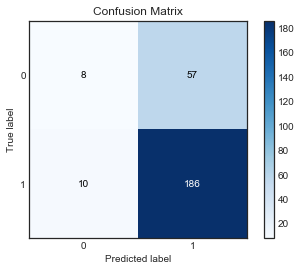

In [13]:
regr_predictions_val = make_predictions(pipeline, X_val)
compute_scores_print_report(regr_predictions_val['prediction'], binarize(Y_val_lab, le), "MLP regression as clf", y_probas=None)

In [14]:
regr_predictions = make_predictions(pipeline, test_df)

Zero percentage 55.036213575880076 Ones Percentage 44.96378642411993


In [15]:
roc_vals = {}

### Keras classifier

In [16]:
# training & preprocessing for keras classifier
n_features = X_train.shape[1] // 2# floor division

steps = [
    ['scaling', preprocessing.StandardScaler()],
    ['feature_selection', SelectKBest(score_func=f_regression, k=n_features)],
]

prep_pipeline = Pipeline(steps, verbose=True)
X_train_p = prep_pipeline.fit_transform(X_train, Y_train_lab)


class_weights = class_weight.compute_class_weight('balanced',
                                                   np.unique(Y_train_lab),
                                                   Y_train_lab)
clf = get_clf_model(n_features, len(le.classes_))
clf.fit(X_train_p, to_categorical(Y_train_lab), epochs=250, class_weight=dict(enumerate(class_weights)))

pipeline = Pipeline([
  *prep_pipeline.steps,
  ('clf', clf)
])

[Pipeline] ........... (step 1 of 2) Processing scaling, total=   0.1s
[Pipeline] . (step 2 of 2) Processing feature_selection, total=   0.0s
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               295040    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 297,172
Trainable params: 297,172
Non-trainable params: 0
______________________________________

33/33 [==============================] - 0s 1ms/step - loss: 0.9770 - accuracy: 0.8226
Epoch 72/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9991 - accuracy: 0.8015
Epoch 73/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9958 - accuracy: 0.8150
Epoch 74/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9701 - accuracy: 0.8236
Epoch 75/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9990 - accuracy: 0.8265
Epoch 76/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9703 - accuracy: 0.8130
Epoch 77/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9987 - accuracy: 0.8140
Epoch 78/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9350 - accuracy: 0.8370
Epoch 79/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9567 - accuracy: 0.8322
Epoch 80/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9610 - accuracy: 0.8140
Epoch 81/250


33/33 [==============================] - 0s 1ms/step - loss: 1.0090 - accuracy: 0.8523
Epoch 153/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0778 - accuracy: 0.8159
Epoch 154/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0505 - accuracy: 0.8255
Epoch 155/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0633 - accuracy: 0.8332
Epoch 156/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0842 - accuracy: 0.8121
Epoch 157/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0717 - accuracy: 0.8073
Epoch 158/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0713 - accuracy: 0.8198
Epoch 159/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0330 - accuracy: 0.8389
Epoch 160/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0689 - accuracy: 0.8322
Epoch 161/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0384 - accuracy: 0.8265
Epoc

33/33 [==============================] - 0s 1ms/step - loss: 0.9958 - accuracy: 0.8466
Epoch 234/250
33/33 [==============================] - 0s 1ms/step - loss: 1.0057 - accuracy: 0.8351
Epoch 235/250
33/33 [==============================] - 0s 2ms/step - loss: 0.9882 - accuracy: 0.8313
Epoch 236/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9666 - accuracy: 0.8514
Epoch 237/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9554 - accuracy: 0.8456
Epoch 238/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9999 - accuracy: 0.8274
Epoch 239/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.8341
Epoch 240/250
33/33 [==============================] - 0s 2ms/step - loss: 0.9741 - accuracy: 0.8476
Epoch 241/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9325 - accuracy: 0.8571
Epoch 242/250
33/33 [==============================] - 0s 1ms/step - loss: 0.9436 - accuracy: 0.8485
Epoc

Instructions for updating:
Please use `model.predict()` instead.

Keras classifier
              precision    recall  f1-score   support

           0       0.24      0.17      0.20        36
           1       0.28      0.22      0.24        50
           2       0.42      0.39      0.40       106
           3       0.34      0.48      0.40        69

    accuracy                           0.35       261
   macro avg       0.32      0.31      0.31       261
weighted avg       0.34      0.35      0.34       261



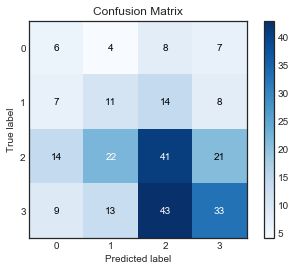

/Users/dansimons/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


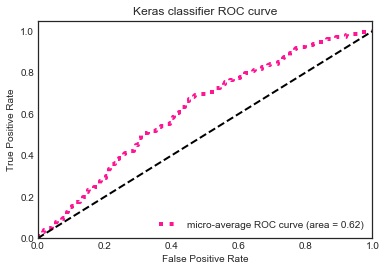

In [17]:
make_predictions_validation(pipeline, X_val, Y_val_lab, le, oh=True, text="Keras classifier")

In [18]:
clf_prediction = make_predictions(pipeline, test_df, le=le, oh=True)
clf_prediction_val = make_predictions(pipeline, X_val, le=le, oh=True)

Zero percentage 69.47953511874684 Ones Percentage 30.520464881253158
Zero percentage 32.95019157088122 Ones Percentage 67.04980842911877


### Naive bayes

In [19]:
# Naive bayes training & pipelining
parameters = {}

n_features = X_train.shape[1] // 2 # floor division

steps = [
    #['scaling', preprocessing.StandardScaler()],
    ['feature_selection', SelectKBest(score_func=f_regression, k=n_features)],
    ['classification', GaussianNB()],
]

pipeline = Pipeline(steps, verbose=True)
grid = GridSearchCV(pipeline, param_grid=parameters, cv=3)
grid.fit(X_train, Y_train_lab)

[Pipeline] . (step 1 of 2) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing classification, total=   0.0s
[Pipeline] . (step 1 of 2) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing classification, total=   0.0s
[Pipeline] . (step 1 of 2) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing classification, total=   0.0s
[Pipeline] . (step 1 of 2) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing classification, total=   0.0s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[['feature_selection',
                                        SelectKBest(k=2304,
                                                    score_func=<function f_regression at 0x1a4399df80>)],
                                       ['classification',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09)]],
                                verbose=True),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


Naive bayes classifier
              precision    recall  f1-score   support

           0       0.28      0.19      0.23        36
           1       0.15      0.29      0.20        21
           2       0.55      0.40      0.46       136
           3       0.34      0.49      0.40        68

    accuracy                           0.38       261
   macro avg       0.33      0.34      0.32       261
weighted avg       0.43      0.38      0.39       261



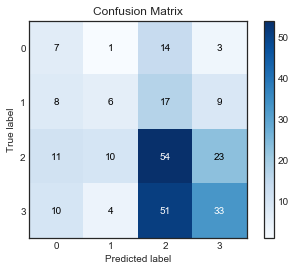

/Users/dansimons/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


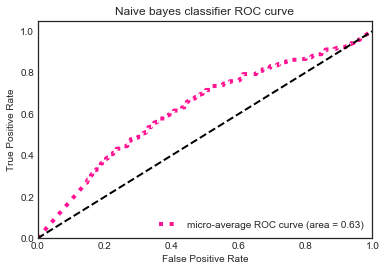

In [20]:
roc_vals['nb'] = make_predictions_validation(grid, X_val, Y_val_lab, le, text="Naive bayes classifier")

In [21]:
nb_prediction = make_predictions(grid, test_df, le=le)
nb_prediction_val = make_predictions(grid, X_val, le=le)

Zero percentage 76.03166582449047 Ones Percentage 23.96833417550952
Zero percentage 21.839080459770116 Ones Percentage 78.16091954022988


### SVM

In [22]:
# Support vector machine training & pipelining 

parameters = {}

n_features = X_train.shape[1] // 2 # floor division

steps = [
    ['scaling', preprocessing.StandardScaler()],
    ['feature_selection', SelectKBest(score_func=f_regression, k=n_features)],
    ['classification', SVC(class_weight='balanced', probability=True)],
]

pipeline = Pipeline(steps, verbose=True)
grid = GridSearchCV(pipeline, param_grid=parameters, cv=2)
grid.fit(X_train, Y_train_lab)

[Pipeline] ........... (step 1 of 3) Processing scaling, total=   0.0s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing classification, total=   5.3s
[Pipeline] ........... (step 1 of 3) Processing scaling, total=   0.0s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing classification, total=   5.0s
[Pipeline] ........... (step 1 of 3) Processing scaling, total=   0.1s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing classification, total=  19.1s


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[['scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)],
                                       ['feature_selection',
                                        SelectKBest(k=2304,
                                                    score_func=<function f_regression at 0x1a4399df80>)],
                                       ['classification',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200,
                                            class_weight='balanced', coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                     


SVC classifier
              precision    recall  f1-score   support

           0       0.08      0.40      0.13         5
           1       0.23      0.25      0.24        36
           2       0.45      0.37      0.41       118
           3       0.44      0.42      0.43       102

    accuracy                           0.38       261
   macro avg       0.30      0.36      0.30       261
weighted avg       0.41      0.38      0.39       261



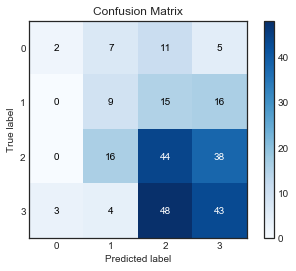

/Users/dansimons/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


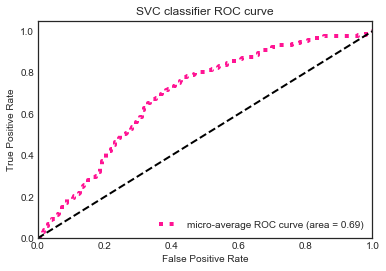

In [23]:
roc_vals['svc'] = make_predictions_validation(grid, X_val, Y_val_lab, le, text="SVC classifier")

In [24]:
svc_prediction = make_predictions(grid, test_df, le=le)
svc_prediction_val = make_predictions(grid, X_val, le=le)

Zero percentage 66.04345629105609 Ones Percentage 33.95654370894391
Zero percentage 15.708812260536398 Ones Percentage 84.2911877394636


### One class SVM

In [25]:
#One class support vector machine - detects abnormal values & we use it to classsify the test set
# since our training data is imbalanced - reads 0 as abnormal values.  Using abnormal detection capability provided 
# by OC-svm to predict the 0-values in test dataset. (Unsupervised)

parameters = {
}

n_features = X_train.shape[1] // 2 # floor division

steps = [
    ['scaling', preprocessing.StandardScaler()],
    ['feature_selection', SelectKBest(score_func=f_regression, k=n_features)],
    ['classification', OneClassSVM(gamma='auto', nu=0.01)],
]

pipeline = Pipeline(steps, verbose=True)
pipeline.fit(X_train, Y_train_lab)

[Pipeline] ........... (step 1 of 3) Processing scaling, total=   0.1s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing classification, total=   0.4s


Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 SelectKBest(k=2304,
                             score_func=<function f_regression at 0x1a4399df80>)),
                ['classification',
                 OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
                             kernel='rbf', max_iter=-1, nu=0.01, shrinking=True,
                             tol=0.001, verbose=False)]],
         verbose=True)

In [26]:
oc_svc_prediction = make_predictions(pipeline, test_df, confidence_values=False)
oc_svc_prediction_val = make_predictions(pipeline, X_val, confidence_values=False)

Zero percentage 69.833249115715 Ones Percentage 30.166750884284994
Zero percentage 9.961685823754788 Ones Percentage 90.03831417624522



One Class SVM
              precision    recall  f1-score   support

           0       0.18      0.46      0.26        26
           1       0.93      0.77      0.84       235

    accuracy                           0.74       261
   macro avg       0.56      0.62      0.55       261
weighted avg       0.85      0.74      0.79       261



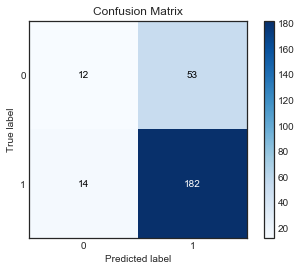

In [27]:
compute_scores_print_report(oc_svc_prediction_val['prediction'], binarize(Y_val_lab, le), "One Class SVM", y_probas=None)

In [28]:
oc_svc_prediction['prediction'].value_counts()

0    8292
1    3582
Name: prediction, dtype: int64

In [29]:
#ensemble learning - combining the result of all 5 classifiers
#every classifier has equal weight in this model
def combine_results(clf_results, threshold):
    # Initialize the predictions with the first set of values
    results_sum =  clf_results[0].copy()
    
    # Combine the remaining ones
    for result in clf_results[1:]:
        results_sum['prediction'] += result['prediction'] # Sum
        
    # Apply a threshold to convert sum into 0 or 1
    results_sum['prediction'] = results_sum['prediction'].map(
        lambda val: 1 if val > threshold else 0
    )
    return results_sum

def save_pred_results(df, fname):
    assert df.shape[1] == 2
    df.to_csv(fname, index=False)

clf_predictions = [
    clf_prediction,
    oc_svc_prediction * 2,
    regr_predictions,
    svc_prediction,
    nb_prediction,
]

combine_results(clf_predictions, threshold=2)['prediction'].value_counts(normalize=True)

0    0.651171
1    0.348829
Name: prediction, dtype: float64

In [30]:
save_pred_results(combine_results(clf_predictions, threshold=2), 'combined_final.csv')

In [31]:
clf_val_predictions = [
    clf_prediction_val,
    oc_svc_prediction_val * 2,
    regr_predictions_val,
    svc_prediction_val,
    nb_prediction_val,
]

combine_results(clf_val_predictions, threshold=2)['prediction'].value_counts(normalize=True)

1    0.911877
0    0.088123
Name: prediction, dtype: float64


Ensemble
              precision    recall  f1-score   support

           0       0.20      0.57      0.30        23
           1       0.95      0.78      0.86       238

    accuracy                           0.76       261
   macro avg       0.57      0.67      0.58       261
weighted avg       0.88      0.76      0.81       261



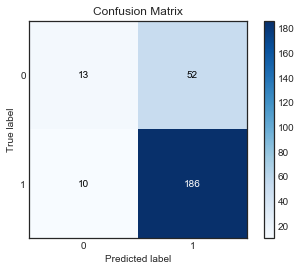

In [32]:
combine_val_predictions = combine_results(clf_val_predictions, threshold=2)
compute_scores_print_report(combine_val_predictions['prediction'], binarize(Y_val_lab, le), "Ensemble", y_probas=None)